In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns

from src.data.preprocess import extend_market_data

# Getting and preprocessing the data

In [4]:
SRW = yf.Ticker("ZW=F")
SRW_data = SRW.history(start ="2014-01-01").drop(['Dividends', 'Stock Splits'], axis=1)
SRW_data = extend_market_data(SRW_data)
SRW_data['Target'] = SRW_data['Log_Return'].shift(-1)
SRW_data.dropna(inplace=True)
SRW_data.head()

,Open,High,Low,Close,Volume,Year,Month,Day,Day_Of_Year,expiry,...,Low-Close,TR,14D_ATR,Volume_Volatility_Ratio,14D_RSI,7D_MA,14D_MA,7D_EMA,14D_EMA,Target
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-23,561.75,578.00,561.50,570.00,47326,2014,1,23,23,2014-03-14,...,0.25,16.75,12.517857,3.391011e+06,35.405405,568.107143,579.017857,569.022517,575.619286,-0.008368
2014-01-24,571.00,573.50,562.50,565.25,39689,2014,1,24,24,2014-03-14,...,7.50,11.00,12.375000,3.049951e+06,27.118644,566.107143,576.125000,568.079388,574.236715,-0.003101
2014-01-27,567.00,572.25,562.75,563.50,44294,2014,1,27,27,2014-03-14,...,2.50,9.50,12.500000,3.420749e+06,26.592798,565.500000,573.107143,566.934541,572.805153,0.004427
2014-01-28,564.00,569.00,564.00,566.00,44179,2014,1,28,28,2014-03-14,...,0.50,5.50,12.303571,3.347173e+06,29.608939,564.535714,570.500000,566.700906,571.897799,-0.025952
2014-01-29,567.00,567.00,550.50,551.50,84576,2014,1,29,29,2014-03-14,...,15.50,16.50,12.017857,6.251879e+06,29.362881,562.821429,567.839286,562.900679,569.178092,0.003620


# Defining the feature columns and the train test split

In [5]:
feature_cols = ['Close', 'Volume', 'Day_Of_Year', 'Year', 'Month', 'Day' ,'DTE', '7D_Volatility', '14D_ATR', '7D_MA', '7D_EMA', '14D_RSI']
splitting_point = '2025-01-01'

scaler = StandardScaler()

X_test_pd = SRW_data[SRW_data.index >= splitting_point][feature_cols]
y_test = SRW_data[SRW_data.index >= splitting_point]['Target']
X_train_pd = SRW_data[SRW_data.index < splitting_point][feature_cols]
y_train = SRW_data[SRW_data.index < splitting_point]['Target']

X_train = scaler.fit_transform(X_train_pd)
X_test = scaler.transform(X_test_pd)

# Linear regression model with CV

Cross-validation R^2 scores on the training set: [-0.01562987 -0.221459   -0.11861645 -0.00773133 -0.01307229]
Average R^2 score: -0.0753
The R^2 score on the testing set: -0.0138


<Axes: title={'center': 'The Linear Regression Model on the training set'}, xlabel='Date', ylabel='Target'>

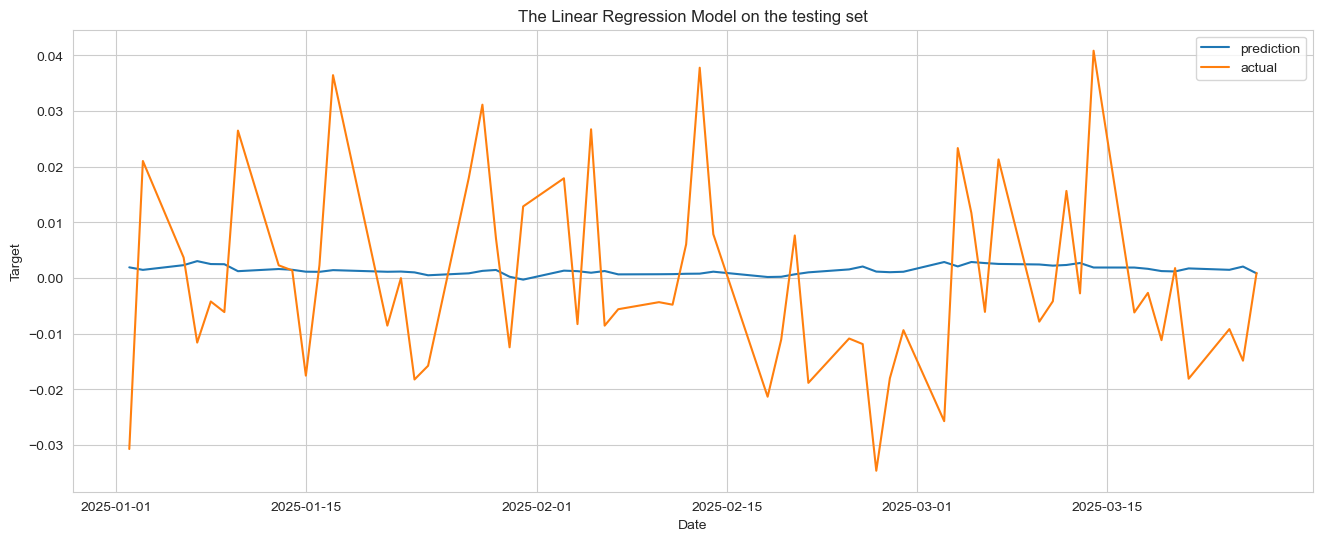

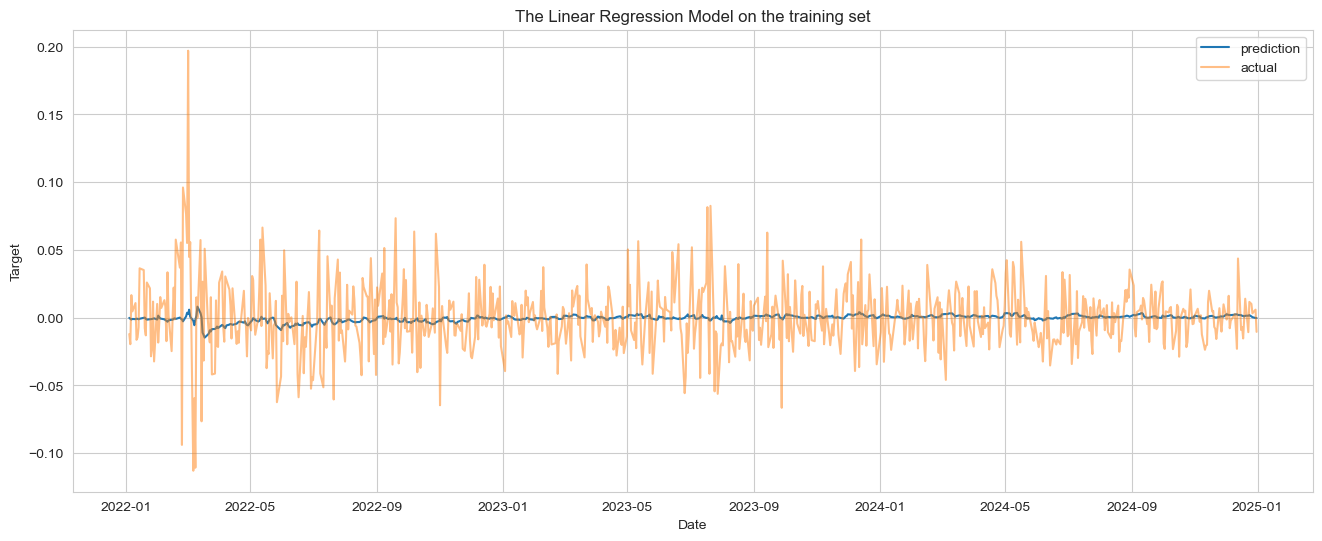

In [6]:
tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"The R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the training set')
sns.lineplot(x=y_train[2000:].index, y=model.predict(X_train[2000:]), label='prediction')
sns.lineplot(x=y_train[2000:].index, y=y_train[2000:], label='actual', alpha = 0.5)

### Understanding the Feature Importance

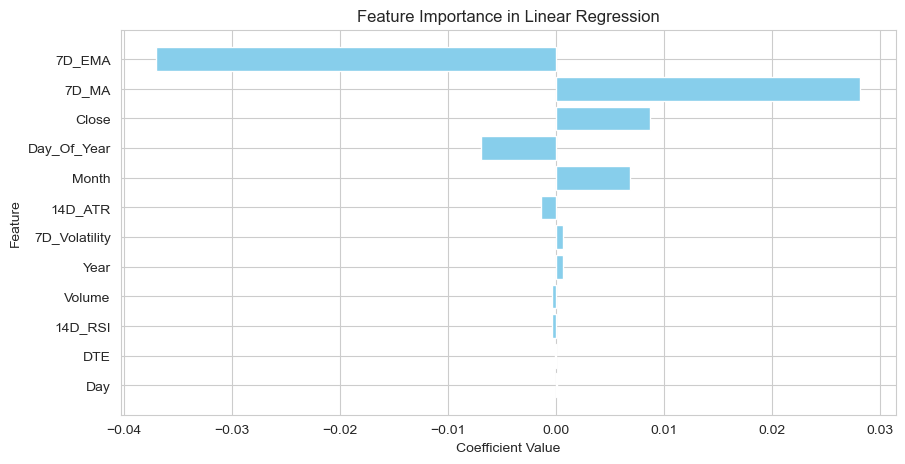

In [7]:
coefficients = model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

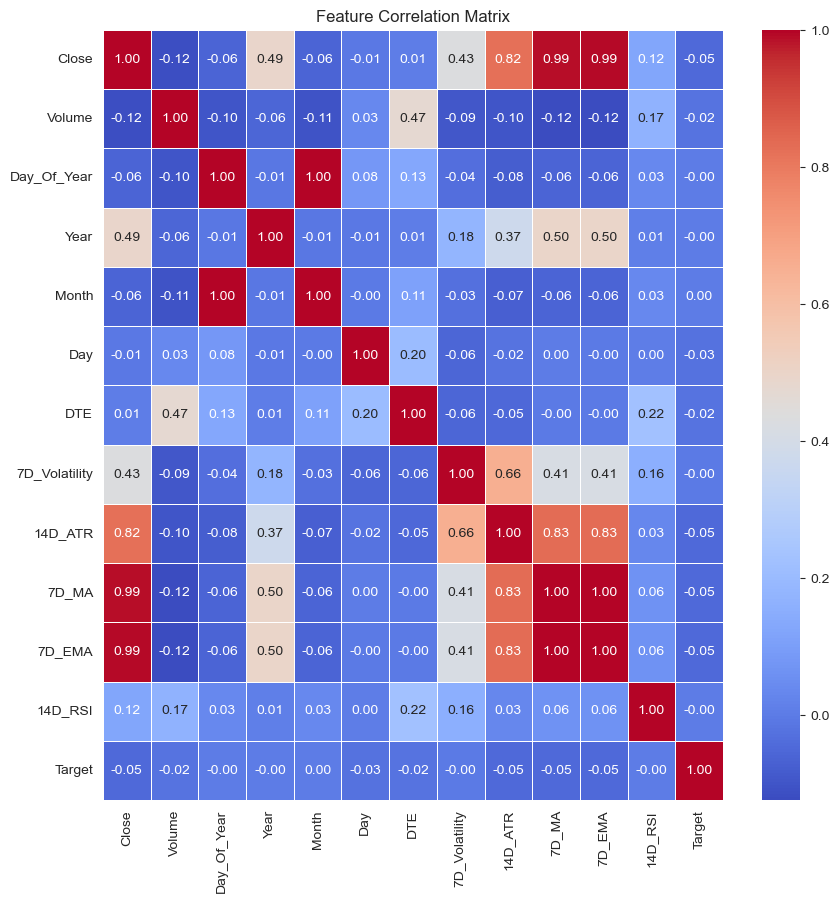

In [8]:
correlation_matrix = X_train_pd.merge(y_train, left_index=True, right_index=True).corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Lasso regression on the market data

Cross-validation R^2 scores on the training set: [ 0.01228114 -0.03780136 -0.03885343  0.00536036 -0.0056159 ]
Average R^2 score: -0.0129
The Lasso Regression R^2 score on the testing set: -0.0030


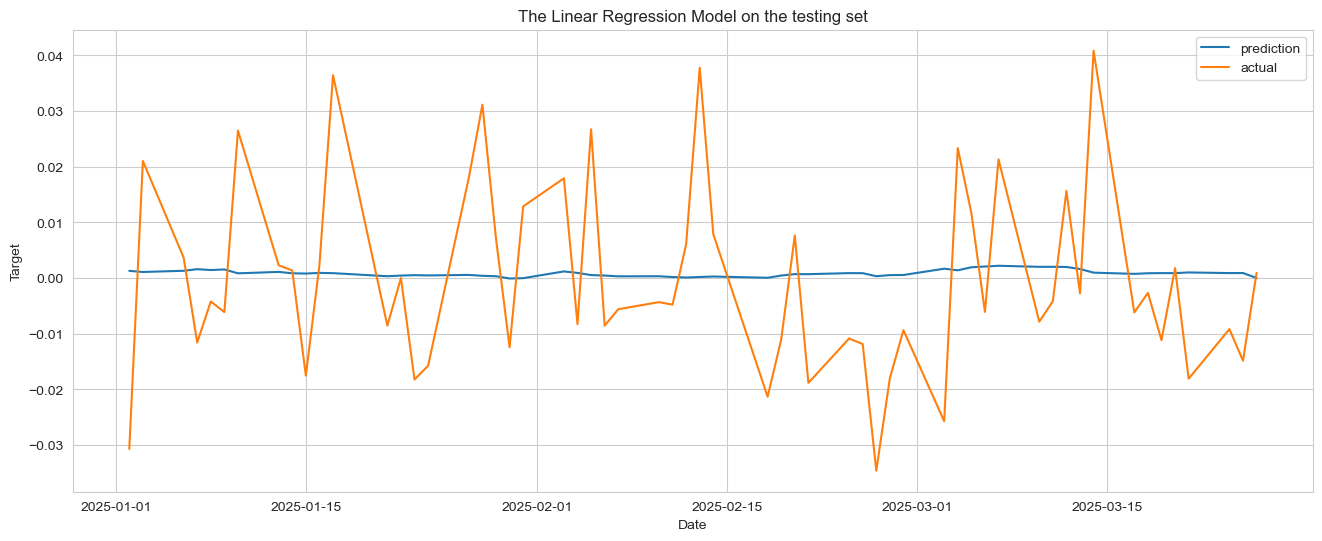

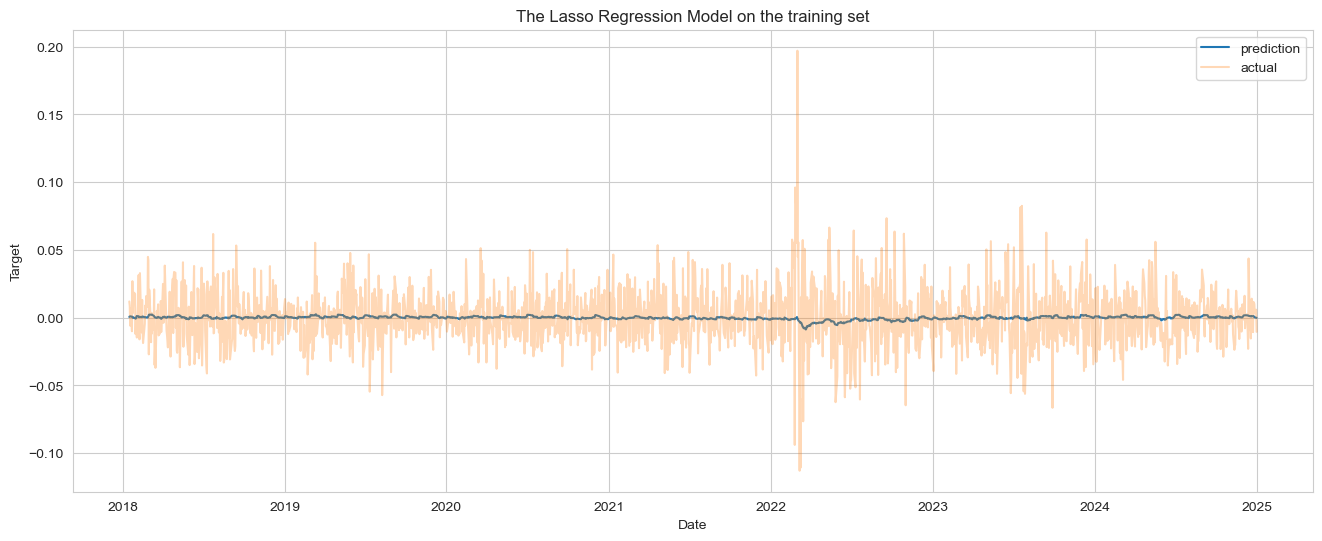

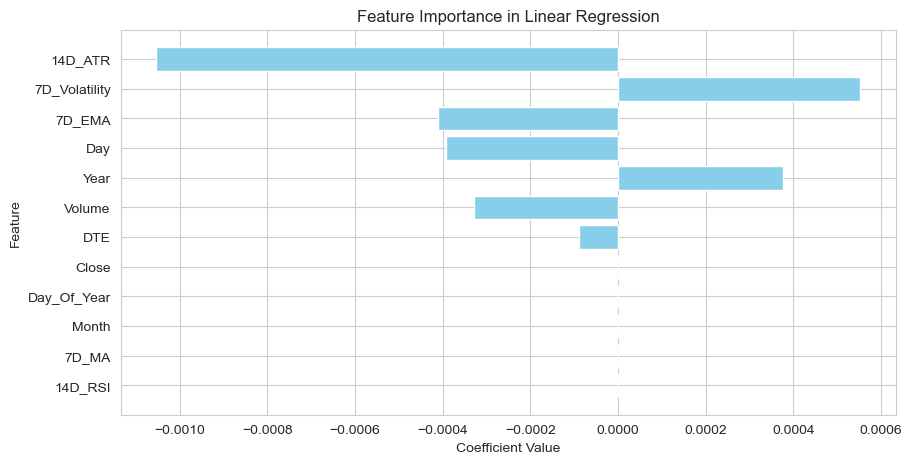

In [9]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(X_train, y_train)

cv_scores = cross_val_score(lasso_model, X_train, y_train, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
print(f"The Lasso Regression R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Lasso Regression Model on the training set')
sns.lineplot(x=y_train[1000:].index, y=lasso_model.predict(X_train[1000:]), label='prediction')
sns.lineplot(x=y_train[1000:].index, y=y_train[1000:], label='actual', alpha = 0.3)

coefficients = lasso_model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## Linear regression model on the training set without 2022 data

Cross-validation R^2 scores on the training set: [-0.02996358 -0.3440984  -0.00460502 -0.07437484  0.00290585]
Average R^2 score: -0.0900
The R^2 score on the testing set: 0.0010


<Axes: title={'center': 'The Linear Regression Model on the training set'}, xlabel='Date', ylabel='Target'>

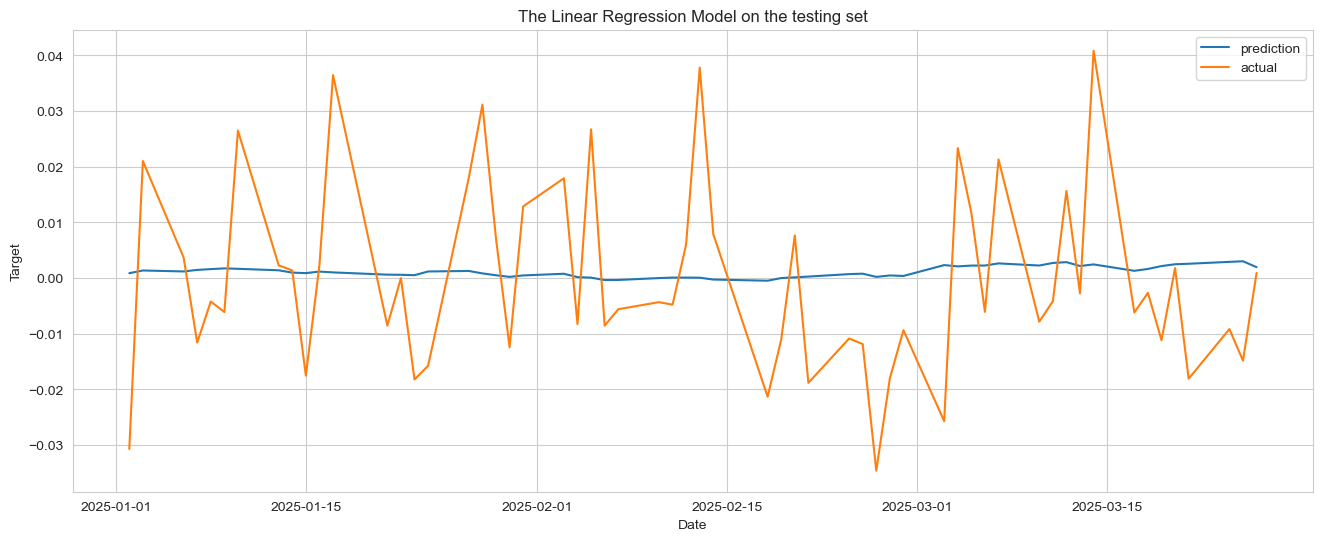

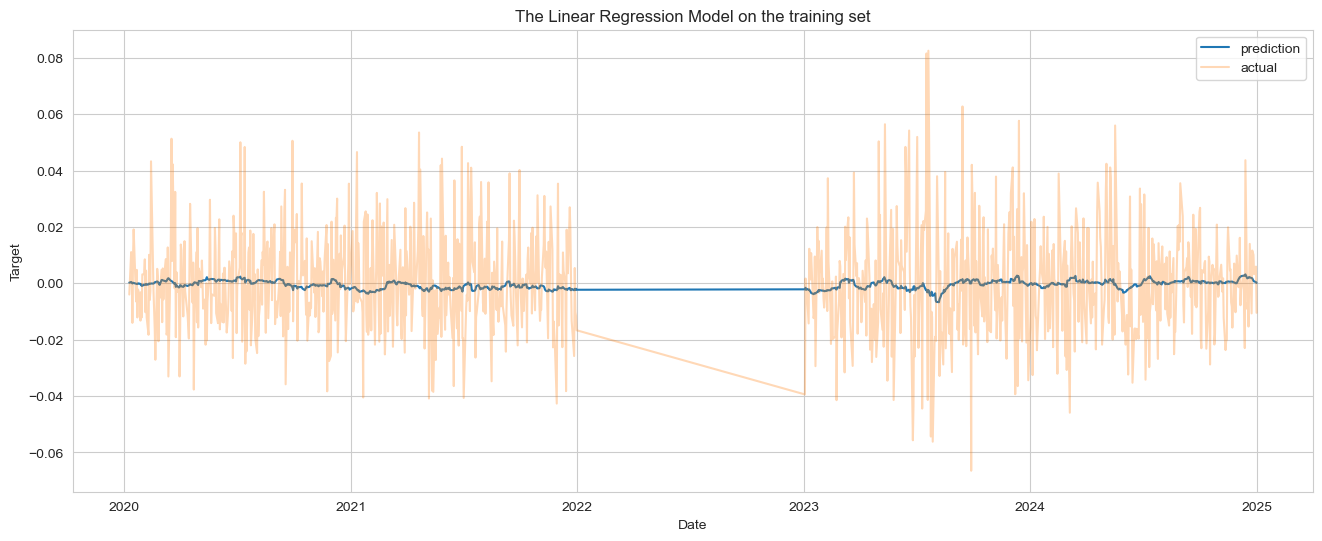

In [10]:
X_train_new = X_train_pd[X_train_pd.index.year != 2022]
y_train_new = y_train[X_train_pd.index.year != 2022]

X_train_new = scaler.fit_transform(X_train_new)
X_test = scaler.transform(X_test_pd)

tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

cv_scores = cross_val_score(model, X_train_new, y_train_new, cv=tscv, scoring='r2')
print(f'Cross-validation R^2 scores on the training set: {cv_scores}')
print(f'Average R^2 score: {np.mean(cv_scores):.4f}')

model.fit(X_train_new, y_train_new)
y_pred = model.predict(X_test)
print(f"The R^2 score on the testing set: {r2_score(y_test, y_pred):.4f}")

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual')

plt.figure(figsize=(16, 6))
plt.title('The Linear Regression Model on the training set')
sns.lineplot(x=y_train_new[1500:].index, y=model.predict(X_train_new[1500:]), label='prediction')
sns.lineplot(x=y_train_new[1500:].index, y=y_train_new[1500:], label='actual', alpha = 0.3)


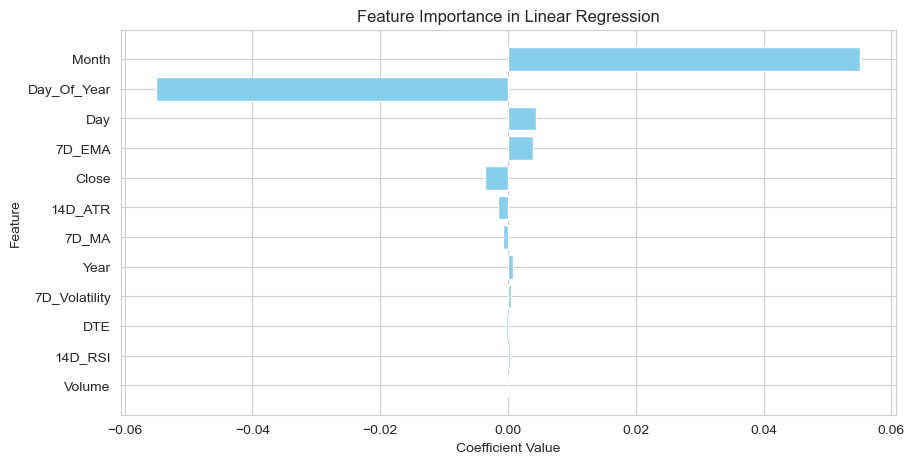

In [11]:
coefficients = model.coef_
coefficients_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coefficients}).sort_values(by="Coefficient", key=abs, ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# XGB Model with CV

In [10]:
tscv = TimeSeriesSplit(n_splits=10)
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    eval_metric=r2_score,
#    device='cuda',
    reg_alpha=0.1,
    reg_lambda=0.1,
#    gamma=0.1,
#    early_stopping_rounds=250,
#    min_child_weight=5,
#    subsample=0.7,
#    colsample_bytree=0.7,
)

cv_scores = cross_val_score(xgb_model, X_train_new, y_train_new, cv=tscv, scoring='r2')
print(f'Cross-validation R2 scores: {cv_scores}')  # Convert to positive MAE values
print(f'Average R2: {np.mean(cv_scores):.4f}')

Cross-validation R2 scores: [-0.04165399 -0.21916223 -0.06153784 -0.03569324 -0.01264824 -0.13930619
 -0.10705546 -0.03592077 -0.01188577 -0.04628647]
Average R2: -0.0711


[0]	validation_0-rmse:0.01800	validation_0-r2_score:0.00055	validation_1-rmse:0.01744	validation_1-r2_score:0.00071
[50]	validation_0-rmse:0.01781	validation_0-r2_score:0.02158	validation_1-rmse:0.01725	validation_1-r2_score:0.02307
[100]	validation_0-rmse:0.01767	validation_0-r2_score:0.03697	validation_1-rmse:0.01718	validation_1-r2_score:0.03070
[150]	validation_0-rmse:0.01755	validation_0-r2_score:0.04995	validation_1-rmse:0.01713	validation_1-r2_score:0.03607
[200]	validation_0-rmse:0.01746	validation_0-r2_score:0.05964	validation_1-rmse:0.01712	validation_1-r2_score:0.03777
[250]	validation_0-rmse:0.01738	validation_0-r2_score:0.06810	validation_1-rmse:0.01710	validation_1-r2_score:0.03932
[300]	validation_0-rmse:0.01731	validation_0-r2_score:0.07645	validation_1-rmse:0.01709	validation_1-r2_score:0.04015
[350]	validation_0-rmse:0.01723	validation_0-r2_score:0.08425	validation_1-rmse:0.01712	validation_1-r2_score:0.03750
[400]	validation_0-rmse:0.01716	validation_0-r2_score:0.091

<Axes: title={'center': 'The XGBoost Model on the training set'}, xlabel='Date', ylabel='Target'>

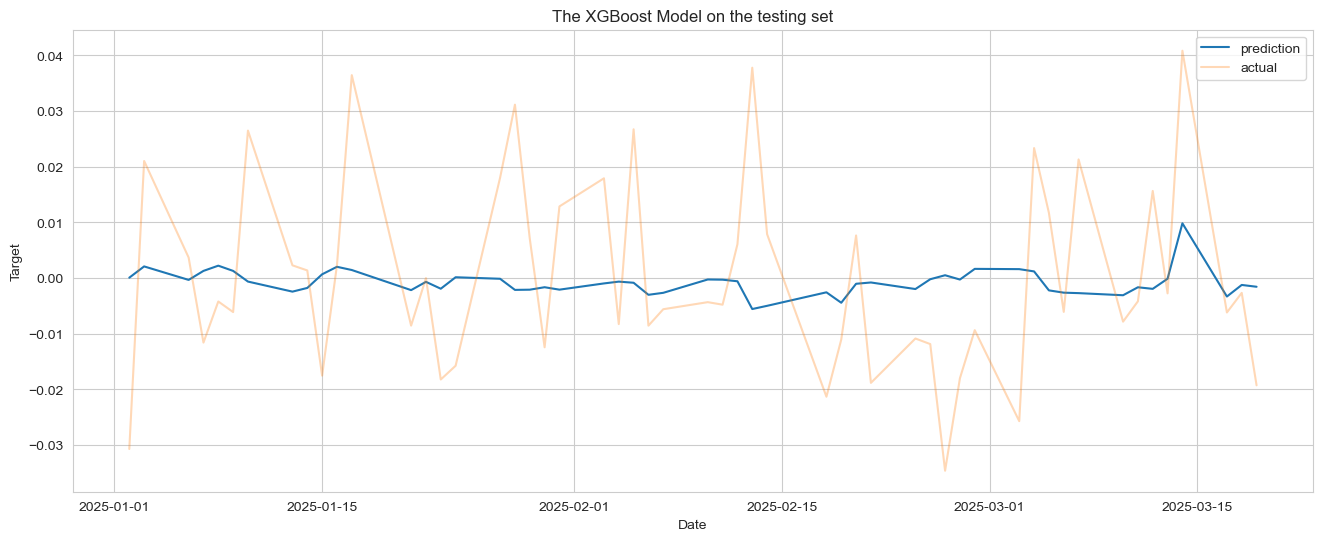

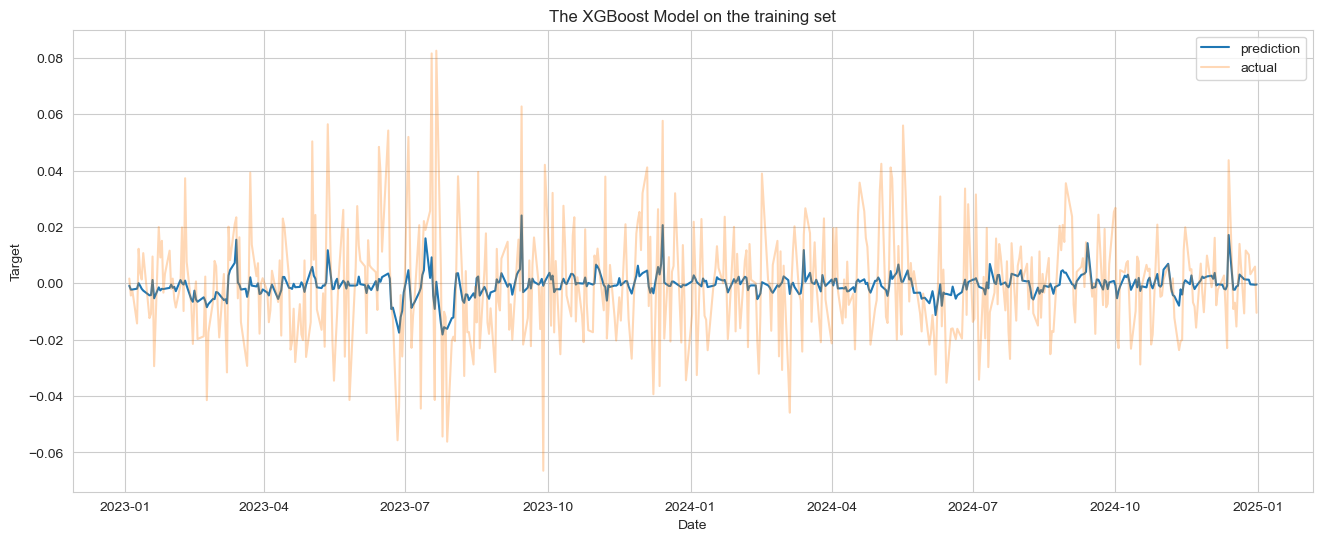

In [11]:
xgb_model.fit(X_train_new, y_train_new, verbose=50,eval_set=[(X_train_new, y_train_new), (X_test, y_test)])
y_pred = xgb_model.predict(X_test)

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the testing set')
sns.lineplot(x=y_test.index, y=y_pred, label='prediction')
sns.lineplot(x=y_test.index, y=y_test, label='actual', alpha = 0.3)

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the training set')
sns.lineplot(x=y_train_new[2000:].index, y=xgb_model.predict(X_train_new[2000:]), label='prediction')
sns.lineplot(x=y_train_new[2000:].index, y=y_train_new[2000:], label='actual', alpha = 0.3)



# NN Model

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [14]:
# Converting the training set and testing set to the torch tensors
X_train, y_train = torch.tensor(X_train_new, dtype=torch.float32), torch.tensor(y_train_new, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader class
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

/var/folders/2h/69hg_xrd4fb4nytgmwvn8ch40000gn/T/ipykernel_11755/35562620.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_train, y_train = torch.tensor(X_train_new, dtype=torch.float32), torch.tensor(y_train_new, dtype=torch.float32)
/var/folders/2h/69hg_xrd4fb4nytgmwvn8ch40000gn/T/ipykernel_11755/35562620.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


In [15]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [16]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#    test_loss /= num_batches
    print(f"Test loss: \n: {test_loss:>0.8f} \n")

In [17]:
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/opt/anaconda3/envs/ErdosAgriDerivPredict/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.073701  [   32/ 2501]
loss: 0.081476  [  352/ 2501]
loss: 0.062379  [  672/ 2501]
loss: 0.073292  [  992/ 2501]
loss: 0.049509  [ 1312/ 2501]
loss: 0.040195  [ 1632/ 2501]
loss: 0.036101  [ 1952/ 2501]
loss: 0.030878  [ 2272/ 2501]


/opt/anaconda3/envs/ErdosAgriDerivPredict/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/ErdosAgriDerivPredict/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 
: 0.09376428 

Epoch 2
-------------------------------
loss: 0.025216  [   32/ 2501]
loss: 0.026152  [  352/ 2501]
loss: 0.019005  [  672/ 2501]
loss: 0.022427  [  992/ 2501]
loss: 0.016238  [ 1312/ 2501]
loss: 0.015456  [ 1632/ 2501]
loss: 0.016596  [ 1952/ 2501]
loss: 0.013115  [ 2272/ 2501]
Test loss: 
: 0.03635499 

Epoch 3
-------------------------------
loss: 0.011864  [   32/ 2501]
loss: 0.008611  [  352/ 2501]
loss: 0.008753  [  672/ 2501]
loss: 0.008282  [  992/ 2501]
loss: 0.006362  [ 1312/ 2501]
loss: 0.005833  [ 1632/ 2501]
loss: 0.004794  [ 1952/ 2501]
loss: 0.004404  [ 2272/ 2501]
Test loss: 
: 0.01632559 

Epoch 4
-------------------------------
loss: 0.004757  [   32/ 2501]
loss: 0.003922  [  352/ 2501]
loss: 0.006058  [  672/ 2501]
loss: 0.003564  [  992/ 2501]
loss: 0.006175  [ 1312/ 2501]
loss: 0.004788  [ 1632/ 2501]
loss: 0.004018  [ 1952/ 2501]
loss: 0.003990  [ 2272/ 2501]
Test loss: 
: 0.00878968 

Epoch 5
-------------------------------
loss: 0.0040

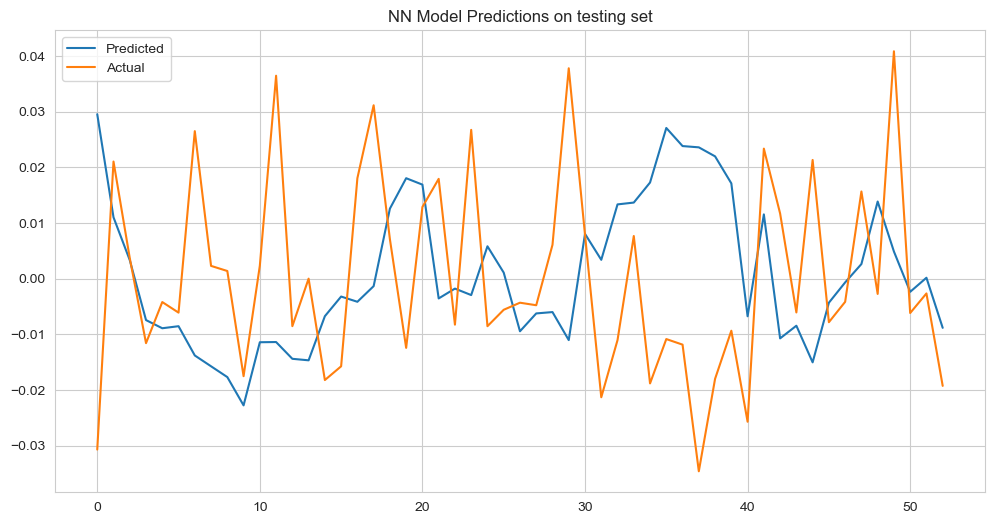

-0.9214910268783569


In [22]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test.to(device)).squeeze().cpu().numpy()

y_pred_test_rescaled = y_pred_test.reshape(-1, 1)
y_test_rescaled = y_test.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(y_pred_test_rescaled, label='Predicted')
plt.plot(y_test_rescaled, label='Actual')
plt.legend()
plt.title("NN Model Predictions on testing set")
plt.show()

print(r2_score(y_test_rescaled, y_pred_test_rescaled))

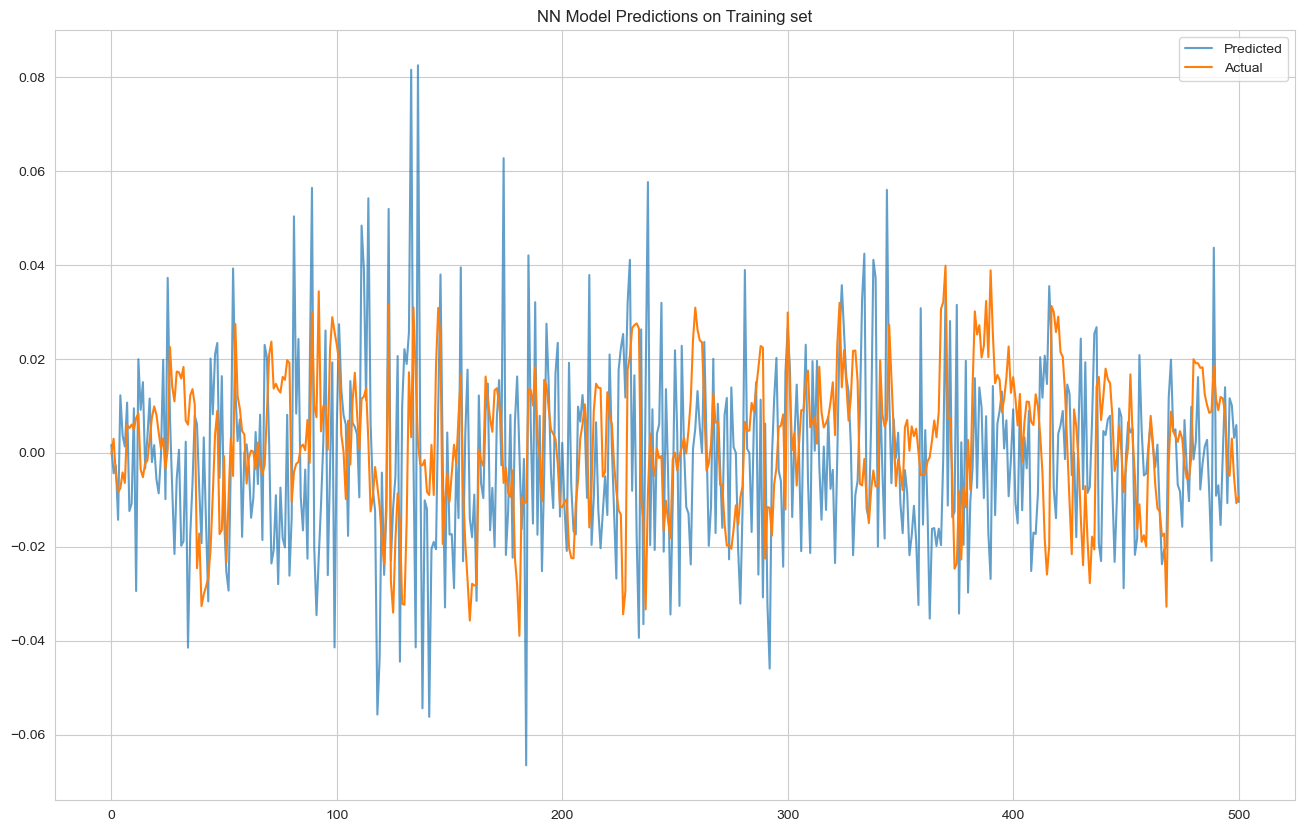

-0.5213358402252197


In [23]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train.to(device)).squeeze().cpu().numpy()

y_pred_train_rescaled = y_pred_train.reshape(-1, 1)
y_train_rescaled = y_train.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(16, 10))
plt.plot(y_train_rescaled[2000:], label='Predicted', alpha=0.7)
plt.plot(y_pred_train_rescaled[2000:], label='Actual')
plt.legend()
plt.title("NN Model Predictions on Training set")
plt.show()

print(r2_score(y_train_rescaled , y_pred_train_rescaled))

# LSTM Model

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler


In [18]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length][-1])
    return np.array(sequences), np.array(targets)

data = SRW_data[feature_cols + ['Target']]

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

SEQ_LENGTH = 60
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X[:-500], dtype=torch.float32), torch.tensor(y[:-500], dtype=torch.float32)
X_test, y_test = torch.tensor(X[-500:], dtype=torch.float32), torch.tensor(y[-500:], dtype=torch.float32)

# Reshape for LSTM (batch_size, seq_length, num_features)
X_train = X_train.view(-1, SEQ_LENGTH, 13)
X_test = X_test.view(-1, SEQ_LENGTH, 13)

# Create DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last output from LSTM
        return out

# Initialize Model
model = LSTMModel()


In [16]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 1000
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss = criterion(y_pred.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.6f}')

Epoch [10/1000], Loss: 0.016165
Epoch [20/1000], Loss: 0.015649
Epoch [30/1000], Loss: 0.015077
Epoch [40/1000], Loss: 0.014120
Epoch [50/1000], Loss: 0.013301
Epoch [60/1000], Loss: 0.012638
Epoch [70/1000], Loss: 0.011637
Epoch [80/1000], Loss: 0.010054
Epoch [90/1000], Loss: 0.008481
Epoch [100/1000], Loss: 0.006723
Epoch [110/1000], Loss: 0.005498
Epoch [120/1000], Loss: 0.004397
Epoch [130/1000], Loss: 0.003938
Epoch [140/1000], Loss: 0.002886
Epoch [150/1000], Loss: 0.002823
Epoch [160/1000], Loss: 0.002202
Epoch [170/1000], Loss: 0.001929
Epoch [180/1000], Loss: 0.001603
Epoch [190/1000], Loss: 0.001351
Epoch [200/1000], Loss: 0.001215
Epoch [210/1000], Loss: 0.001038
Epoch [220/1000], Loss: 0.000892
Epoch [230/1000], Loss: 0.000759
Epoch [240/1000], Loss: 0.000789
Epoch [250/1000], Loss: 0.000705
Epoch [260/1000], Loss: 0.000591
Epoch [270/1000], Loss: 0.000536
Epoch [280/1000], Loss: 0.000502
Epoch [290/1000], Loss: 0.000706
Epoch [300/1000], Loss: 0.000358
Epoch [310/1000], L

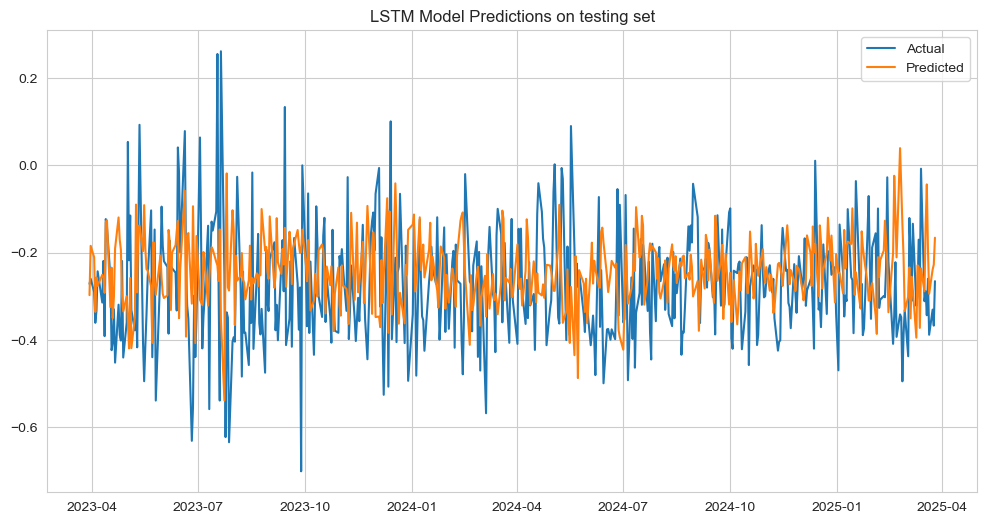

r2 score -0.4498


In [19]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).squeeze().cpu().numpy()

# Inverse transform predictions
# y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
# y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

y_pred_test_rescaled = y_pred_test.reshape(-1, 1)
y_test_rescaled = y_test.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(data.index[-500:], y_test_rescaled, label='Actual')
plt.plot(data.index[-500:], y_pred_test_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Model Predictions on testing set")
plt.show()

print(f"r2 score {r2_score(y_test_rescaled, y_pred_test_rescaled):.4f}")

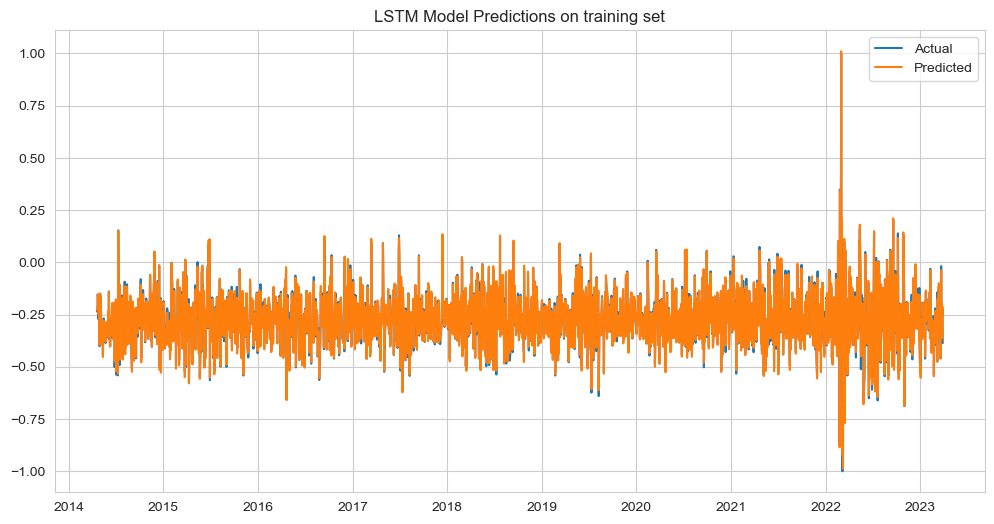

r2 score 0.9889


In [26]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).squeeze().cpu().numpy()

# Inverse transform predictions
# y_pred_test_rescaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
# y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

y_pred_train_rescaled = y_pred_train.reshape(-1, 1)
y_train_rescaled = y_train.numpy().reshape(-1, 1)

# Plot results

plt.figure(figsize=(12, 6))
plt.plot(data.index[60:-500], y_train_rescaled, label='Actual')
plt.plot(data.index[60:-500], y_pred_train_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Model Predictions on training set")
plt.show()

print(f"r2 score {r2_score(y_train_rescaled, y_pred_train_rescaled):.4f}")